## Topic Modeling IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - FInal Project
#### George C. Sturrock
##### April 14, 2019
In the final project for Natural Language Processing, topic modelling of the IMDB movies reviews collected in prior assignments will be the base data set.  The movie review data is automatically scrapped from IMDB.  The data will then be evaluated using Latent Dirichlet Allocation (LDA) 
to produce the topic models.  This project will focus on different data preparation techniques to produce topic models.  Using the raw review text, lemmatized review text, named entities, and hypernyms mixed with named entities will be explored for comparison.
##### Resources
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
#### Import Libraries

In [2]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;
import string

#scikit learn
from sklearn import metrics
from sklearn.feature_extraction import stop_words
#print(stop_words.ENGLISH_STOP_WORDS)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse, Sentence, parsetree, suggest, lemma, wordnet
from pattern.vector import Document, Model, TFIDF, TF, words, stem, PORTER, LEMMA

#pyLDAvis
import pyLDAvis; print("pyLDAvis Versoin:", pyLDAvis.__version__)
import pyLDAvis.sklearn

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.7.1
json: 2.0.9
Numpy Version: 1.16.2
Pandas Version: 0.24.2
Pattern Version: 3.6
pyLDAvis Versoin: 2.1.2


### Data Acquisition
Rocky, Rocky 3 and Rocky 5 will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [3]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 5
         "dRocky 5":"https://www.imdb.com/title/tt0100507/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 5":"https://www.imdb.com/title/tt0100507/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [4]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [5]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw0149538/
1,Rocky,http:/review/rw4247059/
2,Rocky,http:/review/rw0149534/
3,Rocky,http:/review/rw3451942/
4,Rocky,http:/review/rw1979442/


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [6]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
        
    ### Add stemming logic to review body
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
1,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw3451942/,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English
4,Rocky,http:/review/rw1979442/,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the Rocky 3 has the highest average user rating of the reviews collected.  Rocky 5 is a truly horrible movie, and the user ratings back up that statement.  

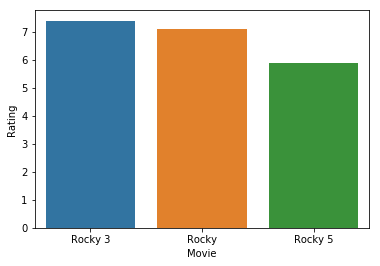

In [7]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Data Engineering
The data engineering section contains the methods used to cleanse, process, and attach lists to the dfReviewDetails dataframe.  
#### Create Additional Features for Topic Modeling
The code chunk shown below performs the steps needed to strip punctuation from the raw text reviews.  Then, three different lists are populated to hold named entities, hypernyms, and lemmatized forms of the raw review text.  The lists are then strung back together per row and added to the dfReviewDetails dataframe.

In [8]:
nerList = []
hypernymList = []
lemmaList = []

sw = stop_words.ENGLISH_STOP_WORDS
table = str.maketrans('', '', string.punctuation)

#tx = tag(dfReviewDetails.Review[2], tokenize=True)

#Create Lemmatize, NER, Hypernyms version of each review for topic modeling
for dfr in dfReviewDetails.Review:
    tlist = []
    poslist = []
    nlist = []
    hlist = []
    t1 = tag(dfr, tokenize=True)
    for t, pos in t1:
        if t not in sw and t not in string.punctuation:
            if pos != "NNPS" and pos != "NNP":
                tlist.append(lemma(t))
                poslist.append(pos)
            else:
                nlist.append(t)
                tlist.append(t)
                poslist.append(pos)
            if pos.startswith("N") or pos.startswith("V"):
                if pos == "NNPS" or pos == "NNP":
                    hlist.append(t)
                else:
                    s = wordnet.synsets(t, pos = pos)
                    try:
                        sout = str(s[0].hypernyms(recursive=False, depth=None))[9:]
                        sout = sout.split('.')[0]
                        hlist.append(sout)
                    except Exception as e:
                        #print(t2, p2, e) 
                        pass
                
    lt = " ".join(l for l in tlist)
    nl = " ".join(n for n in nlist)
    hl = " ".join(h for h in hlist)
    lemmaList.append(lt)
    nerList.append(nl)
    hypernymList.append(hl)


C:\Anaconda\lib\site-packages\pattern\text\__init__.py:625: DeprecationWarning: generator '_read' raised StopIteration
  dict.update(self, (x.split(" ")[:2] for x in _read(self._path) if len(x.split(" ")) > 1))
C:\Anaconda\lib\site-packages\pattern\text\__init__.py:959: DeprecationWarning: generator '_read' raised StopIteration
  for x in _read(self.path):
C:\Anaconda\lib\site-packages\pattern\text\__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [9]:
dfReviewDetails['nerReview'] = nerList
dfReviewDetails['lemmaReview'] = lemmaList
dfReviewDetails['hyperReview'] = hypernymList

In [10]:
dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language,nerReview,lemmaReview,hyperReview
0,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English,Hollywood,i remember initial outrage piece sentimental s...,anger part feed product remark inability be...
1,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English,,the fight scene pathetic act laughable rubbish,military_action area activity waste
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English,Apollo Creed Aki Kaurismaki Rocky VI,grubby late-night fare achieve way succes prim...,agenda succeed property happening message musi...
3,Rocky,http:/review/rw3451942/,2016-04-15,Hate me if you want but I didn't like this film,I'm going to come out and say it. I didn't lik...,3,English,Rocky Stallone Rocky Rocky God Burgess Meredit...,i be go come say i do be like film i know go h...,travel express desire product emotion fact...
4,Rocky,http:/review/rw1979442/,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English,Popeye Network Driver President Oscar Bound Ro...,i go movie come i hear sylvester stallone expe...,product travel perceive belief opinion specul...


The new dfReviewDetails dataframe is saved to disk in the event the data is needed to reproduce these results.

In [11]:
dfReviewDetails.to_pickle("./dfReviewDetailsRocky5.pkl")

#### Vectorize Reviews
Latent Dirichlet Allocation requires a vectorized term matrix fit its model.  Sklearn's count vectorizer will be used for this step.

In [12]:
#tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))
#countVectorizer = CountVectorizer(analyzer='word', min_df=7, stop_words='english', lowercase=True)

### Topic Modelling
Topic modeling for the four different data engineering schemes described above are performed in this section.  Named entity recognition and noun/verb hypernyms combined with named entities produced the best topic modelling results.
##### LDA Model GridSearchCV
Sklearn's GridSearchCV provides a mechanism to evaluate combinations of parameters to arrive at the optimum model.  The parameter grid and GridSearchCV model are created below.

In [16]:
lda = LatentDirichletAllocation()

parmGrid = {'n_components': [2, 3, 4, 5, 6, 7], 
            'learning_method': ['online'], 
            'random_state': [2019], 
            'learning_decay': [0.5, 0.7, 0.9], 
            'max_iter': [5, 10]}

ldaGrid = GridSearchCV(lda, param_grid=parmGrid)

The main function to vectorize, measure, score, and fit the LDA GridSearchCV model.  The function returns the vectorized matrix and fitted model.

In [20]:
def modelTopic2(listIn, minDf):
    countVectorizer = CountVectorizer(analyzer='word', min_df=minDf, stop_words='english', lowercase=True)
    matrix = countVectorizer.fit_transform(listIn)
    cvDense = matrix.todense()
    print("Matrix Sparseness:", round(((cvDense > 0).sum()/cvDense.size), 4))
    print("Count Vectorized Matrix Shape:", matrix.shape)
    clf = ldaGrid.fit(matrix)
    print("Log Likelihood:", round(clf.score(matrix), 4))
    print("Log Likelihood / Feature:", round((clf.score(matrix)/matrix.shape[1]), 4))
    print(clf.best_estimator_)
    #print(clf.best_params_)
    return clf, matrix, countVectorizer

#### LDA for Full Reviews
The full review text is user reviews scrapped directly from IMDB.  It is unaltered at this point.  Statistics such at the sparseness of the matrix, matrix shape, log likelihood, log likelihood per feature, and the LDA model with optimum parameters for the full review data are printed below.

In [21]:
ldaClf, cvReview, cVect = modelTopic2(dfReviewDetails.Review, 10)

Matrix Sparseness: 0.1417
Count Vectorized Matrix Shape: (150, 243)
Log Likelihood: -41322.071
Log Likelihood / Feature: -170.0497
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


The interactive topic model plot shows the interspatial distance between topics along with the top 30 most releveant terms for each topic.  The relevance can be adjusted with a slider on the upper right hand portion of the plot.  The plot shows two total clusters.  Differences between the topics are hard to decipher.  Topic one seems to be centered more around named entities and key terms from Rocky 3 such as "iii", "eye", "tiger", "clubber", and "lang".  Topic 2 seems to be a bit heavier on emotional or sentiment driven terms.

In [22]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvReview, cVect, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  70.335103
1      60.312561 -141.369141       2        1  29.664897, topic_info=    Category        Freq       Term       Total  loglift  logprob
107  Default  148.000000       just  148.000000  30.0000  30.0000
75   Default  217.000000       film  217.000000  29.0000  29.0000
51   Default   64.000000        don   64.000000  28.0000  28.0000
136  Default  246.000000      movie  246.000000  27.0000  27.0000
32   Default   68.000000  character   68.000000  26.0000  26.0000
113  Default  109.000000       like  109.000000  25.0000  25.0000
218  Default   28.000000   underdog   28.000000  24.0000  24.0000
48   Default   51.000000       does   51.000000  23.0000  23.0000
44   Default   23.000000       didn   23.000000  22.0000  22.0000
195  Default   85.000000      story   85.000000  21.0000  21.0000
68   Default   35.000000       feel   35.000000  20.0000  20.0000
109  Default   46.000000       know   46.000000  19.0000  19.0000
53   Default   25.000000      drama   25.000000  18.0000  18.0000
22   Default   63.000000     boxing   63.000000  17.0000  17.0000
184  Default   21.000000        set   21.000000  16.0000  16.0000
49   Default   41.000000      doesn   41.000000  15.0000  15.0000
19   Default   27.000000        bit   27.000000  14.0000  14.0000
110  Default  103.000000       lang  103.000000  13.0000  13.0000
226  Default   65.000000        way   65.000000  12.0000  12.0000
159  Default   18.000000   probably   18.000000  11.0000  11.0000
164  Default   64.000000     really   64.000000  10.0000  10.0000
130  Default   19.000000      maybe   19.000000   9.0000   9.0000
207  Default  115.000000       time  115.000000   8.0000   8.0000
131  Default   45.000000   meredith   45.000000   7.0000   7.0000
86   Default  100.000000       good  100.000000   6.0000   6.0000
179  Default   17.000000     seeing   17.000000   5.0000   5.0000
124  Default   34.000000       make   34.000000   4.0000   4.0000
0    Default   25.000000         10   25.000000   3.0000   3.0000
35   Default   84.000000    clubber   84.000000   2.0000   2.0000
237  Default   20.000000      worst   20.000000   1.0000   1.0000
..       ...         ...        ...         ...      ...      ...
68    Topic2   20.425480       feel   35.643177   0.6584  -4.7772
108   Topic2   11.523369       kind   20.661459   0.6313  -5.3496
73    Topic2    8.806070   fighting   15.887367   0.6251  -5.6186
11    Topic2    5.512827   avildsen    9.995755   0.6201  -6.0869
239   Topic2    9.261274    writing   16.800655   0.6196  -5.5682
219   Topic2   12.148578         ve   22.223299   0.6113  -5.2968
0     Topic2   14.152757         10   25.993134   0.6073  -5.1441
32    Topic2   35.745253  character   68.588546   0.5635  -4.2176
48    Topic2   27.202724       does   51.563831   0.5757  -4.4907
75    Topic2   99.455529       film  217.558829   0.4324  -3.1943
109   Topic2   22.829948       know   46.684130   0.4999  -4.6659
54    Topic2   12.657825      early   23.702099   0.5879  -5.2557
113   Topic2   45.589710       like  109.520257   0.3388  -3.9743
49    Topic2   20.091889      doesn   41.332015   0.4939  -4.7937
136   Topic2   83.595802      movie  246.352652   0.1344  -3.3680
195   Topic2   33.630178      story   85.590385   0.2811  -4.2786
22    Topic2   25.970461     boxing   63.416009   0.3224  -4.5370
124   Topic2   16.480462       make   34.403946   0.4792  -4.9918
226   Topic2   25.705062        way   65.559140   0.2789  -4.5473
164   Topic2   25.132807     really   64.869765   0.2670  -4.5698
207   Topic2   35.687116       time  115.624865   0.0396  -4.2192
131   Topic2   19.650499   meredith   45.640095   0.3725  -4.8159
86    Topic2   31.823358       good  100.720180   0.0631  -4.3338
170   Topic2   99.212174      rocky  781.448600  -0.8487  -3.1967
193   Topic2   35.048864   stallo

#### LDA for Named Entity Recognition
Named entities are proper nouns from the review text.  This could be actor names, character names, nicknames, song names, and movie award names.  

In [23]:
ldaClf, cvNer, cVectNer = modelTopic2(dfReviewDetails.nerReview, 5)

Matrix Sparseness: 0.1227
Count Vectorized Matrix Shape: (150, 55)
Log Likelihood: -6567.2588
Log Likelihood / Feature: -119.4047
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


The named entity topic model produces two topic clusters with adequate token numbers in each.  It is obvious topic 1 is heavily influenced by Rocky 3 named entities.  Topic 2 is lead by named entities from Rocky 5.  Data from the Rocky reviews are likely split fairly evenly between the two topics with any Reviews mentioning Carl Weathers or his character, Apollo Creed, being included in topic 1.  

In [24]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvNer, cVectNer, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  51.797617
1      60.312561 -141.369141       2        1  48.202383, topic_info=   Category        Freq          Term       Total  loglift  logprob
50  Default   61.000000         tommy   61.000000  30.0000  30.0000
31  Default   76.000000          lang   76.000000  29.0000  29.0000
11  Default   61.000000       clubber   61.000000  28.0000  28.0000
13  Default   63.000000         creed   63.000000  27.0000  27.0000
37  Default   62.000000            mr   62.000000  26.0000  26.0000
42  Default  807.000000         rocky  807.000000  25.0000  25.0000
4   Default   49.000000        balboa   49.000000  24.0000  24.0000
2   Default   57.000000        apollo   57.000000  23.0000  23.0000
26  Default   76.000000           iii   76.000000  22.0000  22.0000
49  Default   31.000000         tiger   31.000000  21.0000  21.0000
18  Default   32.000000           eye   32.000000  20.0000  20.0000
19  Default   17.000000          gunn   17.000000  19.0000  19.0000
27  Default   26.000000            iv   26.000000  18.0000  18.0000
16  Default   24.000000          duke   24.000000  17.0000  17.0000
52  Default   27.000000      weathers   27.000000  16.0000  16.0000
39  Default   28.000000        paulie   28.000000  15.0000  15.0000
34  Default   62.000000        mickey   62.000000  14.0000  14.0000
15  Default   15.000000         drago   15.000000  13.0000  13.0000
8   Default   23.000000          carl   23.000000  12.0000  12.0000
35  Default   11.000000      morrison   11.000000  11.0000  11.0000
22  Default   17.000000         hogan   17.000000  10.0000  10.0000
46  Default  111.000000      stallone  111.000000   9.0000   9.0000
3   Default   12.000000      avildsen   12.000000   8.0000   8.0000
51  Default    9.000000            vi    9.000000   7.0000   7.0000
43  Default    9.000000          sage    9.000000   6.0000   6.0000
1   Default   54.000000        adrian   54.000000   5.0000   5.0000
30  Default    8.000000          king    8.000000   4.0000   4.0000
29  Default    8.000000            jr    8.000000   3.0000   3.0000
24  Default   15.000000          hulk   15.000000   2.0000   2.0000
14  Default    7.000000           don    7.000000   1.0000   1.0000
..      ...         ...           ...         ...      ...      ...
27   Topic2   22.965096            iv   26.040645   0.6041  -3.8478
36   Topic2    5.919514         movie    6.731531   0.6012  -5.2035
3    Topic2   11.048709      avildsen   12.636288   0.5955  -4.5795
38   Topic2    6.792460         oscar    8.037146   0.5615  -5.0660
4    Topic2   41.977844        balboa   49.830538   0.5583  -3.2446
28   Topic2    8.211545          john    9.872099   0.5456  -4.8762
0    Topic2    7.262293       academy    8.875148   0.5292  -4.9991
39   Topic2   23.677199        paulie   28.960563   0.5283  -3.8173
23   Topic2    7.232657     hollywood    9.422528   0.4653  -5.0032
40   Topic2    5.072813       picture    6.644969   0.4598  -5.3579
10   Topic2    4.732106  championship    6.686499   0.3840  -5.4274
5    Topic2   11.059255          best   16.685453   0.3185  -4.5785
20   Topic2    3.402679         heavy    5.138397   0.3176  -5.7572
1    Topic2   35.445232        adrian   54.912793   0.2920  -3.4138
41   Topic2    5.452948          rock    8.606740   0.2734  -5.2856
12   Topic2    6.106534         conti    9.672363   0.2698  -5.1724
17   Topic2    6.109704           dvd    9.833945   0.2538  -5.1719
46   Topic2   67.919139      stallone  111.652490   0.2327  -2.7635
42   Topic2  454.686853         rocky  807.700763   0.1552  -0.8622
45   Topic2    6.712418           sly   12.345587   0.1204  -5.0778
25   Topic2   19.104191            ii   36.952314   0.0700  -4.0319
54   Topic2    8.532362         young   18.071744  -0.0207  -4.8379
34   Topic2   14.933928        mickey   62.124286  -0.695

#### LDA for Lemmatised Reviews
A word's lemma is the base form of the word.  For example, the lemma for ran, running, and runs is run.  The theory is lemmatising words will highlight key terms by condensing different forms of the the same lemma into a single term.  

In [25]:
ldaClf, cvLemma, cVectLemma = modelTopic2(dfReviewDetails.lemmaReview, 10)

Matrix Sparseness: 0.1505
Count Vectorized Matrix Shape: (150, 249)
Log Likelihood: -45701.3355
Log Likelihood / Feature: -183.5395
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


The lemmatised topic model is a two-topic result as well.  79.9% of all tokens are contained in Topic 1. The results are a bit difficult to interpret as there is quite a bit of overlap between the key features in both topics.

In [26]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvLemma, cVectLemma, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  79.926537
1      60.312561 -141.369141       2        1  20.073463, topic_info=    Category        Freq         Term       Total  loglift  logprob
186  Default  840.000000        rocky  840.000000  30.0000  30.0000
77   Default  178.000000        fight  178.000000  29.0000  29.0000
227  Default   50.000000        tommy   50.000000  28.0000  28.0000
137  Default   85.000000       mickey   85.000000  27.0000  27.0000
210  Default   87.000000        story   87.000000  26.0000  26.0000
42   Default   95.000000      clubber   95.000000  25.0000  25.0000
235  Default   52.000000         want   52.000000  24.0000  24.0000
228  Default   64.000000        train   64.000000  23.0000  23.0000
43   Default   47.000000         come   47.000000  22.0000  22.0000
240  Default   48.000000          win   48.000000  21.0000  21.0000
225  Default   60.000000        title   60.000000  20.0000  20.0000
48   Default   88.000000        creed   88.000000  19.0000  19.0000
194  Default   27.000000       second   27.000000  18.0000  18.0000
100  Default   46.000000         help   46.000000  17.0000  17.0000
18   Default   56.000000         best   56.000000  16.0000  16.0000
202  Default   36.000000          son   36.000000  15.0000  15.0000
85   Default   24.000000    franchise   24.000000  14.0000  14.0000
6    Default   54.000000       adrian   54.000000  13.0000  13.0000
219  Default   21.000000         tell   21.000000  12.0000  12.0000
163  Default   45.000000         play   45.000000  11.0000  11.0000
237  Default   65.000000          way   65.000000  10.0000  10.0000
156  Default   24.000000       paulie   24.000000   9.0000   9.0000
8    Default   76.000000       apollo   76.000000   8.0000   8.0000
91   Default   15.000000         gunn   15.000000   7.0000   7.0000
61   Default   17.000000         easy   17.000000   6.0000   6.0000
25   Default   15.000000        break   15.000000   5.0000   5.0000
158  Default   28.000000  performance   28.000000   4.0000   4.0000
52   Default   18.000000       defeat   18.000000   3.0000   3.0000
140  Default   15.000000        money   15.000000   2.0000   2.0000
58   Default   13.000000        drago   13.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
26    Topic2    5.842156        bring   13.624823   0.7590  -5.7338
68    Topic2    7.425886         fact   17.453157   0.7512  -5.4939
156   Topic2   10.409967       paulie   24.813555   0.7371  -5.1561
43    Topic2   18.021415         come   47.203831   0.6429  -4.6073
77    Topic2   55.349687        fight  178.027903   0.4375  -3.4852
137   Topic2   29.080845       mickey   85.169535   0.5312  -4.1288
186   Topic2  192.065184        rocky  840.600939   0.1295  -2.2410
235   Topic2   18.901910         want   52.337384   0.5873  -4.5596
240   Topic2   17.450929          win   48.752602   0.5784  -4.6395
202   Topic2   13.820112          son   36.928588   0.6229  -4.8728
210   Topic2   26.620244        story   87.720441   0.4133  -4.2172
100   Topic2   16.350207         help   46.453338   0.5616  -4.7046
42    Topic2   25.684826      clubber   95.135197   0.2964  -4.2530
228   Topic2   19.566099        train   64.548145   0.4122  -4.5251
225   Topic2   17.780113        title   60.540267   0.3805  -4.6208
48    Topic2   20.491386        creed   88.679783   0.1407  -4.4789
18    Topic2   15.675809         best   56.925041   0.3162  -4.7468
6     Topic2   14.629953       adrian   54.303831   0.2942  -4.8158
163   Topic2   12.911346         play   45.915347   0.3371  -4.9408
237   Topic2   14.816748          way   65.875822   0.1138  -4.8031
8     Topic2   15.233722       apollo   76.003937  -0.0015  -4.7754
143   Topic2   22.483037        movie  233.133693  -0.7331  -4.3861
120   Topic2   11.932441         life   50.492701   0.163

#### LDA for Noun and Verb Hypernyms and Named Entities
WordNet is a lexical English database grouped into synsets.  WordNet also contains hypernyms for most words in their database.  A hypernym is a word with a broad meaning where more specific words fall underneath.  This effectively creates a hierarchical structure for all words in the WordNet database.  The use of hypernyms should create an actual topic-based scheme by which the LDA topic model will be created.  Additionally, named entities will be included in the base of tokens used to create the LDA topic model.

In [44]:
ldaClf, cvHyper, cVectHyper = modelTopic2(dfReviewDetails.hyperReview, 8)

Matrix Sparseness: 0.1316
Count Vectorized Matrix Shape: (150, 229)
Log Likelihood: -36499.4678
Log Likelihood / Feature: -159.3863
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


This scheme produces a two topic scheme as well.  The result is interesting as the primary as Rocky 5 reviews do not appear to be a primary driver of topic formation in this result.  Topic 1 appears to be influenced by Rocky 3 named entities and hypernyms.  Topic 2 appears to be driven by concepts typically associated with the original Rocky such as "dramatic_composition" and "musical_composition".  

In [45]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvHyper, cVectHyper, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
0     -60.312317  141.369629       1        1  64.05264
1      60.312561 -141.369141       2        1  35.94736, topic_info=    Category        Freq                       Term       Total  loglift  \
165  Default  578.000000                    product  578.000000  30.0000   
30   Default  113.000000                       case  113.000000  29.0000   
50   Default   63.000000              contact_sport   63.000000  28.0000   
167  Default  117.000000                   property  117.000000  27.0000   
141  Default   32.000000        musical_composition   32.000000  26.0000   
192  Default   29.000000  small_indefinite_quantity   29.000000  25.0000   
67   Default   35.000000       dramatic_composition   35.000000  24.0000   
183  Default  726.000000                      rocky  726.000000  23.0000   
157  Default   52.000000                   perceive   52.000000  22.0000   
181  Default   27.000000                     result   27.000000  21.0000   
193  Default   48.000000                      sound   48.000000  20.0000   
102  Default   88.000000                        iii   88.000000  19.0000   
90   Default   37.000000                      group   37.000000  18.0000   
11   Default   19.000000                  appraisal   19.000000  17.0000   
227  Default   26.000000             written_record   26.000000  16.0000   
61   Default   36.000000                     desire   36.000000  15.0000   
208  Default   31.000000                      think   31.000000  14.0000   
213  Default   29.000000                  time_unit   29.000000  13.0000   
187  Default   16.000000                sense_organ   16.000000  12.0000   
65   Default   55.000000                  diversion   55.000000  11.0000   
216  Default  116.000000                     travel  116.000000  10.0000   
164  Default   13.000000                    present   13.000000   9.0000   
83   Default   14.000000                   feel_for   14.000000   8.0000   
155  Default   21.000000                    payment   21.000000   7.0000   
76   Default   86.000000                   evaluate   86.000000   6.0000   
147  Default   22.000000                      order   22.000000   5.0000   
41   Default   35.000000                  combatant   35.000000   4.0000   
39   Default   14.000000                  cognition   14.000000   3.0000   
40   Default   13.000000                 collection   13.000000   2.0000   
110  Default   36.000000                  intuition   36.000000   1.0000   
..       ...         ...                        ...         ...      ...   
213   Topic2   19.381181                  time_unit   29.713926   0.5958   
147   Topic2   14.361517                      order   22.171744   0.5888   
208   Topic2   20.097425                      think   31.489238   0.5741   
114   Topic2    5.295342                   juvenile    8.390771   0.5628   
58    Topic2   10.739585                        cut   17.073365   0.5595   
144   Topic2    7.922904          nonaccomplishment   12.743950   0.5478   
90    Topic2   23.333645                      group   37.640071   0.5449   
165   Topic2  346.327915                    product  578.572019   0.5099   
61    Topic2   22.148632                     desire   36.124673   0.5339   
50    Topic2   37.632081              contact_sport   63.846236   0.4945   
157   Topic2   30.852187                   perceive   52.805481   0.4857   
193   Topic2   28.577416                      sound   48.525180   0.4936   
30    Topic2   60.586678                       case  113.840107   0.3924   
167   Topic2   55.992211                   property  117.793192   0.2794   
65    Topic2   27.751632                  diversion   55.437421   0.3312   
216   Topic2   47.308681                     travel  116.139918   0.1250   
76    Topic2   36.718778                   evaluate   86.788573   0.1629   
41    Top

### Clustering Topic Model
The topic model for the hypernym and named entity topic model can be represented as a traditional KMeans clusters.  Three KMeans clusters are plotted below.  Three clusters are chosen for plotting as there are three movies in the dataset.  Further analysis would be needed to determine the origin of each clustered point.

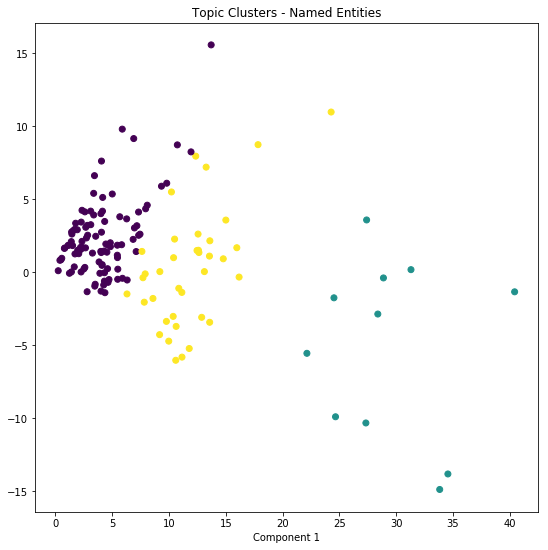

In [43]:
clusters = KMeans(n_clusters=3, random_state=2019).fit_predict(cvNer)

svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(cvHyper)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

plt.figure(figsize=(9, 9))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters - Named Entities", )
plt.show()